### Connect to Drive and importing dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install swifter

In [2]:
import pandas as pd
import swifter
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import sys
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action = "ignore", category = SettingWithCopyWarning)
warnings.simplefilter(action = "ignore", category = pd.errors.PerformanceWarning)

### Read the data

In [7]:
pathTrain = "/content/drive/MyDrive/NLP Study Group/Problem 3/train.csv"
pathTest = "/content/drive/MyDrive/NLP Study Group/Problem 3/test.csv"

dfTrain = pd.read_csv(pathTrain, names = ["text"], sep = "\n")
dfTest = pd.read_csv(pathTest, names = ["text"], sep = "\n")
display(dfTrain)
display(dfTest)

,text
0,Natural_JJ language_NN processing_NN -LRB-_-LR...
1,"Specifically_RB ,_, it_PRP is_VBZ the_DT proce..."
2,"In_IN theory_NN ,_, natural_JJ language_NN pro..."
3,Natural_JJ language_NN understanding_NN is_VBZ...
4,Whether_NNP NLP_NNP is_VBZ distinct_JJ from_IN...
...,...
1296,When_WRB punctuation_NN and_CC similar_JJ clue...
1297,Effective_JJ natural_JJ language_NN processing...
1298,"As_IN an_DT example_NN ,_, processing_NN text_..."
1299,The_DT process_NN of_IN developing_VBG text_NN...


,text
0,"In_IN computational_JJ linguistics_NNS ,_, wor..."
1,The_DT solution_NN to_TO this_DT problem_NN im...
2,Research_NNP has_VBZ progressed_VBN steadily_R...
3,A_DT rich_JJ variety_NN of_IN techniques_NNS h...
4,"Among_IN these_DT ,_, supervised_JJ learning_N..."
...,...
166,WordNet_NNP is_VBZ the_DT most_RBS popular_JJ ...
167,The_DT reason_NN for_IN adopting_VBG the_DT HE...
168,Evaluation_NN measures_NNS ._.
169,During_IN the_DT evaluation_NN of_IN WSD_NNP s...


### Data visualisation

In [8]:
def tokenizeAndTranspose(sentence):
  tokenized = [token.split("_") for token in sentence.split()]
  transposed = [list(i) for i in zip(*tokenized)]
  return transposed

In [9]:
def tokenize(sentence):
  tokenized = [token.split("_") for token in sentence.split()]
  return tokenized

In [13]:
check = [tokenizeAndTranspose(sentence) for sentence in dfTrain["text"].values]
temp = []
for i in range(len(check)):
  temp += check[i][1]

plotdata = dict((x, temp.count(x)) for x in set(temp))  

posList = list(plotdata.keys())
print(posList)
print(len(posList))

['NNP', 'VBN', 'RBS', 'NN', 'RP', 'VBP', 'VBG', 'RB', 'POS', 'TO', 'JJS', 'RBR', 'NNPS', ':', 'EX', 'FW', 'IN', 'MD', 'JJ', 'PRP', 'NNS', 'WRB', '.', 'CD', '-LRB-', 'JJR', 'VBD', 'VBZ', 'PDT', 'WP$', 'LS', 'WP', 'PRP$', 'CC', 'DT', '``', ',', 'VB', 'UH', '-RRB-', 'WDT', "''"]
42


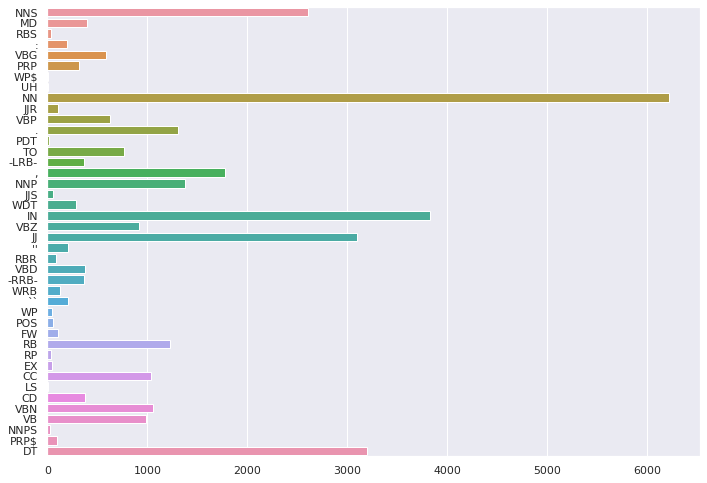

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x = list(plotdata.values()), y = list(plotdata.keys()))

In [14]:
check = [tokenizeAndTranspose(sentence) for sentence in dfTest["text"].values]
temp = []
for i in range(len(check)):
  temp += check[i][1]

plotdata = dict((x, temp.count(x)) for x in set(temp))  

posList = list(plotdata.keys())
print(posList)
print(len(posList))

['NNP', 'VBN', 'RBS', 'NN', 'RP', 'VBP', 'RB', 'VBG', 'POS', 'TO', 'JJS', 'RBR', 'NNPS', ':', 'EX', 'FW', 'IN', 'MD', 'JJ', 'WRB', 'NNS', 'PRP', '.', 'CD', '-LRB-', 'JJR', 'VBD', 'VBZ', 'PDT', 'WP', 'PRP$', 'CC', 'DT', '``', ',', 'VB', '-RRB-', 'WDT', "''"]
39


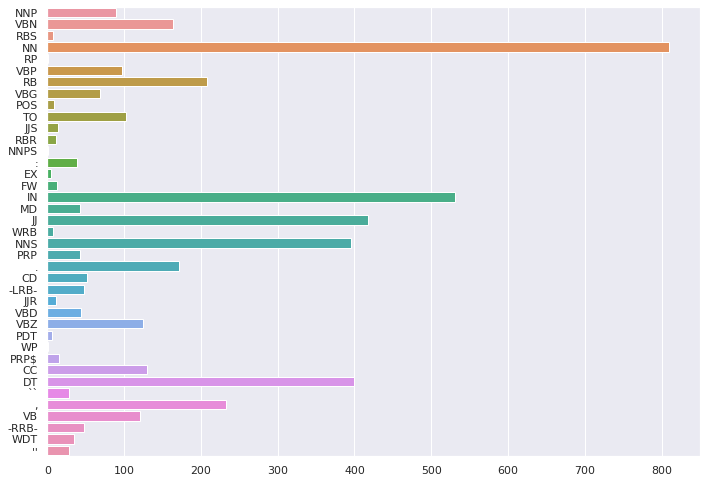

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x = list(plotdata.values()), y = list(plotdata.keys()))

### HMM Model Class

In [4]:
class HMM:
  def __init__(self):
    self._data = None
    self._emissionProb = None
    self._transitionProb = None
    self._sentencePos = None
    self._sentenceSentencePosPos = None
    self._posList = None
    self._vocabList = None

    self._predictData = None
    self._sentenceSentencePosPosPredict = None
    self._sentencePredict = None
    self._sentenceTag = None
    self._predictionList = []
    self._mg = None

  def initiateMatrix(self):
    print("Initiating transition probability")
    self._transitionProb = pd.DataFrame(
        data = np.zeros((len(self._posList)-1, len(self._posList)-1), dtype = float), 
        index = list(set(self._posList) - set(['</S>'])),
        columns = list(set(self._posList) - set(['<S>']))
      )
    
    for i in range(len(self._sentenceSentencePosPos)):
      for j in range(len(self._sentenceSentencePosPos[i][1])):
        if j != 0: 
          context = self._sentenceSentencePosPos[i][1][j]
          given = self._sentenceSentencePosPos[i][1][j-1]
          self._transitionProb[context].loc[given] += 1

    self._transitionProb = self._transitionProb.div(self._transitionProb.sum(axis=1), axis=0)
    print("Done!")

    print("Initiating emission probability")
    self._emissionProb = pd.DataFrame(
        data = np.zeros((len(self._posList), len(self._vocabList)), dtype = float),
        index = self._posList,
        columns = self._vocabList
    )

    for i in range(len(self._sentencePos)):
      for j in range(len(self._sentencePos[i])):
        vocab = self._sentencePos[i][j][0]
        pos = self._sentencePos[i][j][1] 
        self._emissionProb[vocab.lower()].loc[pos] += 1

    self._emissionProb = self._emissionProb.div(self._emissionProb.sum(axis=1), axis=0)
    print("Done!")

  def smoothMatrix(self):
    self._transitionProb = self._transitionProb.replace(0, 0.0001607717041800643/2)

  def countProb(self, prevTag, currentTag, word):
    return self._emissionProb[word][currentTag] * self._transitionProb[currentTag][prevTag]

  def tokenizeAndTranspose(self, sentence):
    tokenized = [token.split("_") for token in sentence.split()]
    transposed = [list(i) for i in zip(*tokenized)]
    return transposed
  
  def tokenize(self, sentence):
    tokenized = [token.split("_") for token in sentence.split()]
    return tokenized

  def startEndMarker(self, sentence):
    return str("<s>_<S> ") + sentence + str(" </s>_</S>")

  def countPosTagAndVocab(self):
    temp = []
    for i in range(len(self._sentenceSentencePosPos)):
      temp += self._sentenceSentencePosPos[i][1]

    posList = dict((x, temp.count(x)) for x in set(temp))  
    self._posList = list(posList.keys())

    temp = []
    for i in range(len(self._sentenceSentencePosPos)):
      temp += self._sentenceSentencePosPos[i][0]

    vocabList = dict((x.lower(), temp.count(x.lower())) for x in set(temp))  
    self._vocabList = [vocab.lower() for vocab in list(vocabList.keys())]
    
  def fit(self, data):
    self._data = data.copy().swifter.apply(self.startEndMarker)
    self._sentencePos = [self.tokenize(sentence) for sentence in self._data["text"].values]
    self._sentenceSentencePosPos = [self.tokenizeAndTranspose(sentence) for sentence in self._data["text"].values] 

    self.countPosTagAndVocab()
    self.initiateMatrix()
    self.smoothMatrix()

  def accuracy(self):
    correctCount = 0
    totalCount = 0
    for i in range(len(self._predictionList)):
      prediction = self._predictionList[i][1:-1]
      actual = self._sentenceSentencePosPosPredict[i][1][1:-1]
      
      for j in range(len(prediction)):
        totalCount += 1
        if prediction[j] == actual[j]: correctCount += 1

    return correctCount / totalCount

  def predict(self, data, dataFrame = True, printStep = False, getResult = False):
    print("preprocessing data")
    self._predictionList = []

    if dataFrame:
      self._predictData = data.copy().swifter.apply(self.startEndMarker)
      self._sentenceSentencePosPosPredict = [self.tokenizeAndTranspose(sentence) for sentence in self._predictData["text"].values]
    else:
      rebuildSentence = ""
      preprocessedData = "<s> " + data + " </s>" 
      preprocessedData = preprocessedData.split()
      preprocessedData = [pdat + "_MASK" for pdat in preprocessedData]

      for i in preprocessedData:
        rebuildSentence = rebuildSentence + i + " "

      rebuildSentence.strip() 
      self._sentenceSentencePosPosPredict = [self.tokenizeAndTranspose(sentence) for sentence in [rebuildSentence]]

    self._sentencePredict = [sentence[0] for sentence in self._sentenceSentencePosPosPredict]
    self._sentenceTag = [sentence[1] for sentence in self._sentenceSentencePosPosPredict]

    
    
    for i in range(len(self._sentencePredict)):
      for j in range(len(self._sentencePredict[i])):
        if self._sentencePredict[i][j].lower() not in self._emissionProb.columns:
          self._emissionProb[self._sentencePredict[i][j].lower()] = 1
          self._emissionProb[self._sentencePredict[i][j].lower()]['<S>'] = 0
          self._emissionProb[self._sentencePredict[i][j].lower()]['</S>'] = 0
    print("Done!")

    print("Processing HMM")
    for i in range(len(self._sentencePredict)):
      listPath = []
      listProb = []

      for j in range(len(self._sentencePredict[i])):
        tempProb = []
        tempPath = []

        if j == 0:
          listPath.append(['<S>'])
          listProb.append(1)
        else:  
          prevKeyword = self._sentencePredict[i][j-1].lower()
          currentKeyword = self._sentencePredict[i][j].lower()
          prevTag = [prev[-1] for prev in listPath] 
          currentTag = self._emissionProb[currentKeyword][self._emissionProb[currentKeyword] > 0].index.to_list()

          for k in range(len(currentTag)):
            bestProb = 0
            bestTag = None
            
            for l in range(len(prevTag)):
              if self.countProb(prevTag[l], currentTag[k], currentKeyword) * listProb[l] > bestProb:
                bestProb = self.countProb(prevTag[l], currentTag[k], currentKeyword) * listProb[l]
                bestTag = [prevTag[l], currentTag[k]] 
              if l == len(prevTag)-1:
                for path in listPath:
                  if path[-1] == prevTag[l]:
                    tempPath.append(path[:-1] + bestTag)
                    tempProb.append(bestProb)

          listPath = tempPath
          listProb = tempProb
          if printStep is True: print(tempPath, tempProb)

      self._predictionList.append(listPath[0])

    print("Done!")
    if dataFrame: print("Accuracy: ", self.accuracy())
    if getResult is True: return self.getPrediction(dataFrame)

  def getPrediction(self, dataFrame):
    predictionHolder = []

    for i in range(len(self._predictionList)):
      sentenceHolder = ""
      prediction = self._predictionList[i][1:-1]
      word = self._sentenceSentencePosPosPredict[i][0][1:-1]

      for j in range(len(prediction)):
        sentenceHolder = sentenceHolder + str(word[j]) +"_"+ str(prediction[j]) + " "

      predictionHolder.append(sentenceHolder.strip())
    
    if dataFrame: 
      return pd.DataFrame(predictionHolder, columns =['text'])
    else:
      return predictionHolder[0]


### Train HMM

In [5]:
hmm = HMM()
hmm.fit(dfTrain)

Initiating transition probability
Done!
Initiating emission probability
Done!


### Test HMM

In [6]:
res = hmm.predict(dfTest, dataFrame = True, printStep = False, getResult = True)
display(res)

preprocessing data
Done!
Processing HMM
Done!
Accuracy:  0.9062020600482139


,text
0,"In_IN computational_NNP linguistics_NNS ,_, wo..."
1,The_DT solution_NN to_TO this_DT problem_NN im...
2,Research_NN has_VBZ progressed_VBD steadily_RB...
3,A_DT rich_JJ variety_NN of_IN techniques_NNS h...
4,"Among_IN these_DT ,_, supervised_JJ learning_N..."
...,...
166,WordNet_NNP is_VBZ the_DT most_RBS popular_JJ ...
167,The_DT reason_NN for_IN adopting_VBG the_DT HE...
168,Evaluation_NN measures_NNS ._.
169,During_IN the_DT evaluation_NN of_IN WSD_JJ sy...


In [146]:
sentence = "Natural Language Processing Laboratory in Nara Institute of Science and Technology"
res = hmm.predict(sentence, dataFrame = False, printStep = True, getResult = True)
display(res)

preprocessing data
Done!
Processing HMM
[['<S>', 'NNP'], ['<S>', 'JJ']] [0.00020810327292744246, 0.00293954353683873]
[['<S>', 'NNP', 'NNP'], ['<S>', 'JJ', 'NN']] [3.3719794726192106e-07, 3.063187440033033e-05]
[['<S>', 'JJ', 'NN', 'NNP'], ['<S>', 'JJ', 'NN', 'NN'], ['<S>', 'JJ', 'NN', 'VBG']] [3.6559195215154354e-10, 4.243905407647011e-08, 1.8857118931689873e-09]
[['<S>', 'JJ', 'NN', 'NN', 'JJS'], ['<S>', 'JJ', 'NN', 'NN', ','], ['<S>', 'JJ', 'NN', 'NN', 'RB'], ['<S>', 'JJ', 'NN', 'NN', '-RRB-'], ['<S>', 'JJ', 'NN', 'NN', 'FW'], ['<S>', 'JJ', 'NN', 'NN', 'PRP'], ['<S>', 'JJ', 'NN', 'NN', "''"], ['<S>', 'JJ', 'NN', 'NNP', 'NNPS'], ['<S>', 'JJ', 'NN', 'NN', 'NNP'], ['<S>', 'JJ', 'NN', 'NN', '-LRB-'], ['<S>', 'JJ', 'NN', 'NN', 'POS'], ['<S>', 'JJ', 'NN', 'NN', 'EX'], ['<S>', 'JJ', 'NN', 'NN', 'VBP'], ['<S>', 'JJ', 'NN', 'NN', ':'], ['<S>', 'JJ', 'NN', 'NN', 'LS'], ['<S>', 'JJ', 'NN', 'NN', 'WRB'], ['<S>', 'JJ', 'NN', 'NN', 'IN'], ['<S>', 'JJ', 'NN', 'NN', '.'], ['<S>', 'JJ', 'NN', 'NN', 

'Natural_JJ Language_NN Processing_VBG Laboratory_NN in_IN Nara_NNP Institute_NNP of_IN Science_NN and_CC Technology_NN'